In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

# %matplotlib inline

from time import time
from operator import itemgetter
from datetime import datetime
from collections import defaultdict
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import subprocess
import sys

Populating the interactive namespace from numpy and matplotlib


# Functions

In [2]:
def finish(text=None):
    os.system("paplay /usr/share/sounds/gnome/default/alerts/drip.ogg")
    
    if text:
        os.system("echo " + text + " | festival --tts")
    else:
        os.system("paplay /usr/share/sounds/gnome/default/alerts/glass.ogg")

In [3]:
import subprocess
import sys

In [4]:
bestLogloss = 0.460876581644
def evaluate(model, X, y, string, more = ""):
    title = string + " score: " + more
    score = model.score(X, y)
    scoreLogloss = log_loss(y, model.predict_proba(X))
    
    currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    if model.get_params().has_key('forest'):
        modelExplaination = model.get_params()['forest'].__class__.__name__ + str(model.get_params()['forest'].get_params())
    else:
        modelExplaination = model.__class__.__name__  + str(model.get_params())
    
    logline = str(score) + ";" + str(scoreLogloss) + ";" + currentDate + ";" + str(modelExplaination) + ";" + more
    
    with open("evaluate"+string+".log", "a") as myfile:
        myfile.write(logline+"\n")
    
    print title
    print score
    print str(scoreLogloss)  + " compare to best score: " + str(scoreLogloss-bestLogloss) 
    
    finish("Evaluate finished!")

# Load

In [5]:
kaggleTrain = pd.read_csv("kaggle/train.csv", header = 0)
kaggleTest = pd.read_csv("kaggle/test.csv", header = 0)

In [6]:
print "Kaggle Train count: " + str(len(kaggleTrain))
print "Kaggle Test count:  " + str(len(kaggleTest))

Kaggle Train count: 114321
Kaggle Test count:  114393


## Columns listing

In [7]:
#print train.schema.fields
columnsDict = {}
columnsDict = defaultdict(lambda: list(), columnsDict)
for col in kaggleTrain.columns:
    typeKey = str(kaggleTrain[col].dtype)
    colName = col
    
    if colName == 'ID':
        print "We have the ID columns, type: " + typeKey
        continue
    if colName == 'target':
        print "We have the target columns, type: " + typeKey
        continue
        
    if typeKey == "object":
        if len(kaggleTrain[col].unique()) < 9 : # Because v71 has 9 distinct value and some missing in the testing set
            columnsDict['dummies'].append(colName)
            

    columnsDict[typeKey].append(colName)

print ""
for ct, cl in columnsDict.iteritems():
    print ct + " " + str(len(cl))

We have the ID columns, type: int64
We have the target columns, type: int64

dummies 10
int64 4
object 19
float64 108


In [8]:
# Add dummies
kaggleTrainDummies = pd.get_dummies(kaggleTrain[columnsDict['dummies']])
kaggleTrain = pd.concat([kaggleTrain, kaggleTrainDummies], axis=1)

kaggleTestDummies = pd.get_dummies(kaggleTest[columnsDict['dummies']])
kaggleTest = pd.concat([kaggleTest, kaggleTestDummies], axis=1)

In [9]:
print set(kaggleTrainDummies.columns) - set(kaggleTestDummies.columns)
print set(kaggleTestDummies.columns) - set(kaggleTrainDummies.columns)

set([])
set([])


# Split

In [10]:
train, test = train_test_split(kaggleTrain, test_size = 0.2)

In [11]:
train[columnsDict['object']].apply(pd.Series.nunique)

v3          3
v22     16628
v24         5
v30         7
v31         3
v47        10
v52        12
v56       119
v66         3
v71         9
v74         3
v75         4
v79        18
v91         7
v107        7
v110        3
v112       22
v113       35
v125       90
dtype: int64

# Prepare X and y

In [12]:
print len(columnsDict['float64']) +  len(columnsDict['int64'])

112


In [13]:
catEncoders = dict()
catProbability = dict()
nbrTestMissing = dict()
nbrTestMissing = defaultdict(lambda: {"nbrMissing": 0, 'nbrDistinct': 0}, nbrTestMissing)
# Create the mapping from categorie to int
for col in columnsDict['object']:
    # Create dictionnary
    uniqueValues = kaggleTrain[col].unique()
    dictValues = dict()
    dictValues = defaultdict(lambda: -1, dictValues)       
    for v in uniqueValues:
        if v is nan:
            continue
        if not v in dictValues:
            dictValues[v] = len(dictValues)
    dictValues[nan] = -1
    
    
    # Cat probability
    df = pd.pivot_table(kaggleTrain, values='target', columns=[col], aggfunc=np.average) # index=['A', 'B']
    dictProba = df.to_dict()
    dictProba = defaultdict(lambda: -1, dictProba)
    
    # If value is in the training but not in the testing, then map to missing -1
    uniqueValuesTesting = kaggleTest[col].unique()
    for v in set(uniqueValuesTesting) - set(uniqueValues):
        dictValues[v] = -1
        dictProba[v] = -1
        nbrTestMissing[col] = {"nbrMissing": nbrTestMissing[col]['nbrMissing'] + 1, 'nbrDistinct': len(uniqueValues)}

    catEncoders[col] = dictValues
    catProbability[col] = dictProba
print "Number of missing value per column in the Testing set"
print nbrTestMissing

Number of missing value per column in the Testing set
defaultdict(<function <lambda> at 0x7f1365b2b500>, {'v56': {'nbrMissing': 8, 'nbrDistinct': 123}, 'v22': {'nbrMissing': 5209, 'nbrDistinct': 18211}, 'v71': {'nbrMissing': 3, 'nbrDistinct': 9}, 'v113': {'nbrMissing': 1, 'nbrDistinct': 37}})


In [14]:
#print catEncoders['v56']
print catProbability['v56']

defaultdict(<function <lambda> at 0x7f1365b2b668>, {'BD': 0.92682926829268297, 'BE': 1.0, 'BF': 0.92592592592592593, 'BG': 0.79032258064516125, 'BA': 0.91116751269035534, 'AN': 0.5561797752808989, 'BC': 1.0, 'BL': 0.73361344537815121, 'BM': 0.95781071835803877, 'BN': 0.66666666666666663, 'BO': 1.0, 'BH': 0.9152542372881356, 'BI': 0.97938144329896903, 'BJ': 0.8511727078891258, 'BK': 0.86427795874049951, 'BT': 1.0, 'BU': 0.94736842105263153, 'BV': 0.7793575566087414, 'BW': 0.77103338912871111, 'BP': 1.0, 'BQ': 0.97077922077922074, 'BR': 1.0, 'BS': 0.92063492063492058, 'BX': 0.79235760634462871, 'BY': 0.85245901639344257, 'BZ': 0.71898522442152213, 'CP': 0.90133779264214042, 'AZ': 0.85642317380352639, 'BB': -1, 'AW': 0.83796514366462549, 'CK': 1.0, 'CJ': 1.0, 'CI': 0.81081081081081086, 'B': 1.0, 'CO': 0.80303030303030298, 'D': 1.0, 'CM': 0.63358778625954193, 'CL': 0.88888888888888884, 'CC': 0.6143790849673203, 'H': 1.0, 'CA': 0.58064516129032262, 'J': -1, 'CG': 1.0, 'L': 1.0, 'CE': 1.0, '

In [15]:
# Choose Encoder or Proba
catForEncoders = ['v22', 'v56']
catEncoders = { your_key: catEncoders[your_key] for your_key in catForEncoders }
catProbability = { your_key: catProbability[your_key] for your_key in set(catProbability.keys()) - set(catForEncoders) }

In [16]:
def prepareX(df, isTrainning):
    colsToAdd = columnsDict['float64'] + columnsDict['int64']
    
    dfX = df[colsToAdd]
    dfX = dfX.fillna(-1) # -1 is a good missing value encoder because everything is >= 0
    
    for col in colsToAdd:
        dfX[col+"_m"] = df[col]
        
    # Add categorical features, and replace categories with int
    dfX[columnsDict['object']] = df[columnsDict['object']]
    #dfX = dfX.replace(catEncoders) # catEncoders
    #dfX = dfX.replace(catProbability) # catEncoders
    
    # Add dummies
    dfX[kaggleTrainDummies.columns] = df[kaggleTrainDummies.columns]
    
    # Features selection
    if True:
        featToKeep = ['v50', 'v66', 'v113', 'v47', 'v110', 'v10', 'v31', 'v129', 'v12', 'v79', 'v56', 'v14', 'v62', 'v114_m', 'v34_m', 'v40_m', 'v21_m', 'v24', 'v38_m', 'v22', 'v125', 'v72_m', 'v123_m', 'v88_m', 'v28_m', 'v82_m', 'v58_m', 'v100_m', 'v68_m', 'v131', 'v1_m', 'v124_m', 'v45_m', 'v46', 'v37_m', 'v119_m', 'v89_m', 'v98_m', 'v36', 'v85_m', 'v120_m', 'v5_m', 'v16', 'v54_m', 'v35', 'v63_m', 'v6_m', 'v78_m', 'v99_m', 'v126_m', 'v112', 'v97_m', 'v94', 'v122_m', 'v57_m', 'v117_m', 'v2_m', 'v86_m', 'v51_m', 'v84_m', 'v11_m', 'v4_m', 'v130_m', 'v42', 'v18_m', 'v53_m', 'v115_m', 'v118', 'v101_m', 'v9_m', 'v61_m', 'v103_m', 'v127_m', 'v87_m', 'v8_m', 'v7_m', 'v32_m', 'v90_m', 'v81_m', 'v59_m', 'v27_m', 'v128_m', 'v20_m', 'v26_m', 'v105_m', 'v108_m', 'v30', 'v73_m', 'v13_m', 'v102_m', 'v25_m', 'v52', 'v121_m', 'v93_m', 'v41', 'v69_m', 'v95_m', 'v104_m', 'v116_m', 'v80_m', 'v111_m', 'v15_m', 'v43_m', 'v70_m', 'v55_m', 'v106_m', 'v60_m', 'v39_m', 'v19_m', 'v33_m', 'v83_m', 'v76_m', 'v44_m', 'v77_m', 'v48_m', 'v65_m', 'v109_m', 'v67_m', 'v29_m', 'v17_m', 'v49_m', 'v92_m', 'v23', 'v96_m', 'v64_m', 'v71', 'v3', 'v107', 'v91', 'v74', 'v75']
        featToKeep = ['v50_m', 'v56', 'v66', 'v12_m', 'v114_m', 'v10_m', 'v34', 'v40', 'v66_C', 'v14', 'v79', 'v21_m', 'v22', 'v47', 'v125', 'v110', 'v110_B', 'v66_B', 'v31', 'v113', 'v110_A', 'v31_A', 'v112', 'v66_A', 'v52', 'v129', 'v62', 'v24', 'v24_E', 'v31_B', 'v107', 'v91', 'v30', 'v82_m', 'v115_m', 'v88_m', 'v6_m', 'v120_m', 'v119_m', 'v69_m', 'v124_m', 'v102_m', 'v24_D', 'v90', 'v57_m', 'v68_m', 'v1_m', 'v78_m', 'v99_m', 'v45_m', 'v16_m', 'v28_m', 'v126_m', 'missing', 'v100', 'v87', 'v131_m', 'v98_m', 'v70_m', 'v36', 'v39_m', 'v108', 'v37_m', 'v81', 'v53_m', 'v85_m', 'v117_m', 'v58_m', 'v32', 'v27_m', 'v19_m', 'v122_m', 'v44_m', 'v42_m', 'v86_m', 'v7_m', 'v127_m', 'v11_m', 'v55_m', 'v9_m', 'v18_m', 'v103_m', 'v2_m', 'v123_m', 'v109_m', 'v80_m', 'v54_m', 'v25_m', 'v26', 'v73_m', 'v15_m', 'v97_m', 'v63_m', 'v20_m', 'v4_m', 'v89_m', 'v35_m', 'v118_m', 'v94_m', 'v5_m', 'v8_m', 'v116_m', 'v46_m', 'v104_m', 'v83', 'v49', 'v111_m', 'v105_m', 'v51', 'v59_m', 'v43_m', 'v13_m', 'v95_m', 'v128_m', 'v84_m', 'v60_m', 'v101_m', 'v61_m', 'v130_m', 'v121_m', 'v92_m', 'v77_m', 'v24_C', 'v67_m', 'v65_m', 'v33_m', 'v76', 'v93_m', 'v41_m', 'v29_m', 'v96_m', 'v48_m', 'v17_m', 'v106_m', 'v71', 'v64_m', 'v72_m', 'v75', 'v75_D', 'v75_B', 'v30_C', 'v23', 'v91_A', 'v107_E', 'v107_B', 'v107_C', 'v91_G', 'v38', 'v91_B', 'v107_D', 'v91_C', 'v31_C', 'v91_F', 'v107_A', 'v24_B', 'v3', 'v30_G', 'v74_B', 'v74', 'v30_D', 'v3_C', 'v110_C', 'v24_A', 'v74_C', 'v30_E', 'v107_F', 'v91_E', 'v30_F', 'v30_A', 'v3_A', 'v91_D', 'v3_B', 'v30_B', 'v107_G', 'v75_C', 'v75_A', 'v74_A']
        #featToKeep = featToKeep[:len(featToKeep)-50] # Remove the last 50 less important feature
        featToKeep = [x for x in featToKeep if x not in columnsDict['dummies']] # Remove dummy columns
        featToKeep = [x for x in featToKeep if x in dfX.columns] # Remove unknow columns
        featToKeep = featToKeep + kaggleTrainDummies.columns.tolist() # Add dummies columns
        dfX = dfX[featToKeep]
    
    # Features creation:
    dfX['missing'] = df.isnull().sum(axis=1)
    
    finish("Prepare X finished!")
    return dfX

In [17]:
def prepareY(df):   
    return df[["target"]].values.ravel()

In [18]:
X_train = prepareX(train, True)
y_train = prepareY(train)

In [19]:
X_test = prepareX(test, False)
y_test = prepareY(test)

In [20]:
colsMissingValues = X_train.isnull().sum()
print len(train.columns)
print len(X_train.columns)
print len(X_test.columns)
#print set(train.columns) - set(X_train.columns)
print len(colsMissingValues)

178
212
212
212


# Model 1 - Stacking
TODO = Cross Validation ?

In [21]:
X_m1_train, X_m2_train, y_m1_train, y_m2_train = train_test_split(X_train, y_train, test_size = 0.5)

In [22]:
import imputerproba
reload(imputerproba)
from imputerproba import ImputerProba
model1 = ImputerProba(columnsEncod=[],
                      columnsProba=catProbability.keys(),
                      verbose=1)

In [23]:
model1.fit(X_m1_train, y_m1_train)

Fit, lengh X: 45728
Column proba: v30 is not in X, skip.
Column proba: v31 is not in X, skip.
Column proba: v91 is not in X, skip.
Column proba: v24 is not in X, skip.
Column proba: v74 is not in X, skip.
Column proba: v66 is not in X, skip.
Column proba: v110 is not in X, skip.
Column proba: v107 is not in X, skip.
Column proba: v3 is not in X, skip.
Column proba: v75 is not in X, skip.


<imputerproba.ImputerProba instance at 0x7f1364507fc8>

In [24]:
X_m2_train = model1.transform(X_m2_train)

Transform
Column proba: v30 is not in X, skip.
Column proba: v31 is not in X, skip.
Column proba: v91 is not in X, skip.
Column proba: v24 is not in X, skip.
Column proba: v74 is not in X, skip.
Column proba: v66 is not in X, skip.
Column proba: v110 is not in X, skip.
Column proba: v107 is not in X, skip.
Column proba: v3 is not in X, skip.
Column proba: v75 is not in X, skip.


In [25]:
X_m2_test = model1.transform(X_test)

Transform
Column proba: v30 is not in X, skip.
Column proba: v31 is not in X, skip.
Column proba: v91 is not in X, skip.
Column proba: v24 is not in X, skip.
Column proba: v74 is not in X, skip.
Column proba: v66 is not in X, skip.
Column proba: v110 is not in X, skip.
Column proba: v107 is not in X, skip.
Column proba: v3 is not in X, skip.
Column proba: v75 is not in X, skip.


# Model

In [26]:
sqrtNbrFeat = int(sqrt(len(X_m2_train.columns)))
print sqrtNbrFeat

14


In [27]:
#.setNumTrees(150).setMaxDepth(6)
clf = RandomForestClassifier(n_estimators=150,
                             n_jobs=-1,
                             max_depth=10,
                             #max_features=sqrtNbrFeat,
                             criterion='gini') #  max_depth=7

In [28]:
#clf.fit(X_m2_train, y_train)

# Pipeline

In [29]:
imputer = Imputer(missing_values="NaN",
                  strategy="mean",
                  axis=0)

In [30]:
catEncoders.keys()

['v56', 'v22']

In [31]:
import imputerproba
reload(imputerproba)
from imputerproba import ImputerProba
imputerProba = ImputerProba(columnsEncod=(catEncoders.keys() + [x+'_m' for x in catEncoders.keys()]),
                            columnsProba=[],
                            verbose=1)

In [32]:
len(X_m2_train)

45728

In [33]:
estimator = Pipeline([("imputerProba", imputerProba),
                      ("imputer", imputer),
                      ("forest", clf)
                     ])

In [34]:
estimator.fit(X_m2_train, y_m2_train)
finish()

Fit, lengh X: 45728
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.
Transform
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.


## Scoring

In [35]:
evaluate(estimator, X_m2_train, y_m2_train, "Training", "estimator+missingFeat+dummy")

Transform
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.
Transform
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.
Training score: estimator+missingFeat+dummy
0.783283764871
0.444215642437 compare to best score: -0.0166609392073


In [36]:
evaluate(estimator, X_m2_test, y_test, "Testing", "estimator+missingFeat+dummy")

Transform
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.
Transform
Column encod: v56_m is not in X, skip.
Column encod: v22_m is not in X, skip.
Testing score: estimator+missingFeat+dummy
0.775770828778
0.483604776289 compare to best score: 0.022728194645


## Features Analysis

In [37]:
featToKeep = []
def feature_analysis(model, X):
    importancePd = pd.DataFrame(X.columns, columns=["feature"])
    importancePd["importance"] = model.feature_importances_
    
    importancePd = importancePd.sort(['importance'], ascending=[0])
    importancePd = importancePd.set_index(['feature'])
    
    print importancePd.head(n=10)

    plt.figure();
    pylab.rcParams['figure.figsize'] = (30, 3)
    importancePd[:50].plot(kind='bar');
    importancePd[50:200].plot(kind='bar');
    plt.axhline(0, color='k')
           
    featToKeep = []
    for index, row in importancePd.iterrows():
        #print row['importance']
        #print index
        
        if not "_m" in index:
            indexWithM = index + "_m"
            if index not in importancePd.columns:
                continue
            imp = importancePd[importancePd.index==index].importance.item()
            impWithM = importancePd[importancePd.index==indexWithM]
            if len(impWithM):
                impWithM = impWithM.importance.item()
            
                if impWithM <= imp:
                    #print index + " is better        impNotM: " + str(impWithM) + " <= imp: " + str(imp)
                    featToKeep.append(index)
                else:
                    #print indexWithM + " is better   impNotM: " + str(impWithM) + " > imp: " + str(imp)
                    featToKeep.append(indexWithM)
            else:
                featToKeep.append(index)
                
    print "Features to keep (use only if all the features are here from prepareX):"
    print featToKeep
    

         importance
feature            
v50_m      0.153844
v79        0.033723
v12_m      0.031284
v10_m      0.029604
v66_C      0.021286
v66_C      0.021065
v56        0.020195
v31_A      0.018759
v114_m     0.018392
v47        0.017677
Features to keep (use only if all the features are here from prepareX):
[]


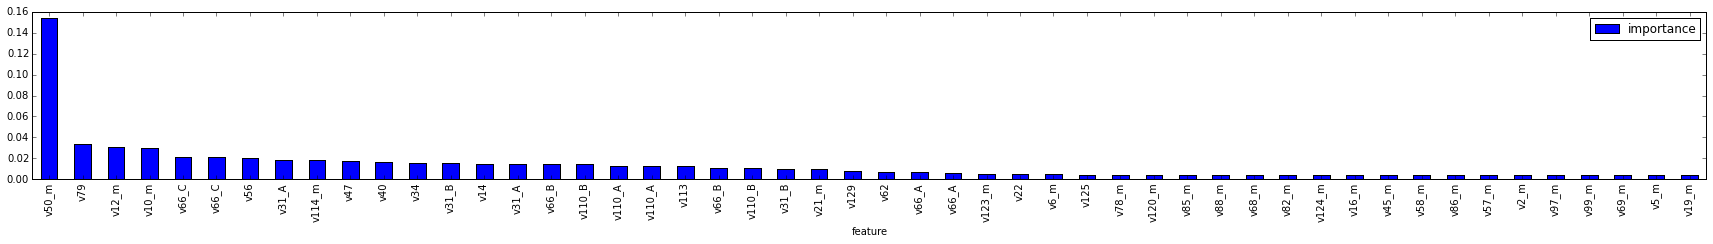

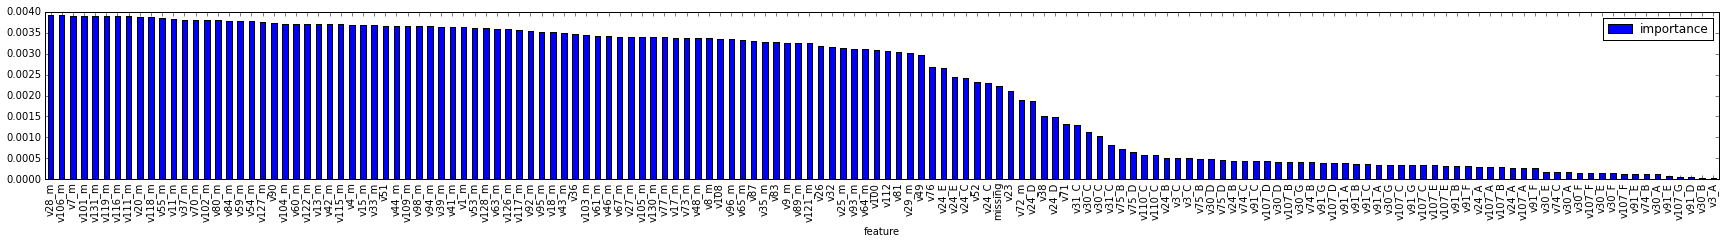

In [38]:
feature_analysis(clf, X_m2_train)

# Grid search

In [39]:
# Utility function to report best scores
def report(grid_scores, n_top=3, save=False):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if save:
            currentDate = str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            logline = str("{0}".format(i + 1)) + ";" + "{0:.5f};{1:.5f}".format(score.mean_validation_score,np.std(score.cv_validation_scores)) + ";" + currentDate + ";" + "{0}".format(score.parameters)
            with open("gridSearch.log", "a") as myfile:
                myfile.write(logline+"\n")

In [40]:
# specify parameters and distributions to sample from
modelName = "forest__"
param_dist = {modelName+"max_depth": [None],          # Default -> None | If Nonen then nodes are expanded until min_samples_split (Ignored if max_leaf_nodes is not None.)
              modelName+"max_features": sp_randint(sqrtNbrFeat-4, sqrtNbrFeat+4),#sp_randint(14, 24),      # Default -> sqrt(n_features) ~14
              modelName+"min_samples_split": sp_randint(1, 5), # Default -> 2 (useless if mex_depth not None)
              modelName+"min_samples_leaf": sp_randint(1, 15),  # Default -> 1
              modelName+"bootstrap": [False]              # Default -> True
              #modelName+"criterion": ["gini", "entropy"] # gini
             }

# run randomized search
n_iter_search = 20
grid_search = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="log_loss")

In [41]:
start = time()
grid_search.fit(X_m2_train, y_m2_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(grid_search.grid_scores_)
finish()

RandomizedSearchCV took 3726.93 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 8, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 2
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 11, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 3
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 13, 'forest__max_depth': None, 'forest__min_samples_split': 1}



In [42]:
report(grid_search.grid_scores_, 20, True)

Model with rank: 1
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 16, 'forest__min_samples_leaf': 8, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 2
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 11, 'forest__max_depth': None, 'forest__min_samples_split': 3}

Model with rank: 3
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 13, 'forest__max_depth': None, 'forest__min_samples_split': 1}

Model with rank: 4
Mean validation score: -0.478 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest__max_features': 17, 'forest__min_samples_leaf': 9, 'forest__max_depth': None, 'forest__min_samples_split': 4}

Model with rank: 5
Mean validation score: -0.479 (std: 0.002)
Parameters: {'forest__bootstrap': False, 'forest

In [43]:
evaluate(grid_search.best_estimator_, X_m2_test, y_test, "Testing", "GridSearchBest")

Testing score: GridSearchBest
0.782812158321
0.469735480948 compare to best score: 0.00885889930415


         importance
feature            
v50_m      0.123513
v12_m      0.034926
v10_m      0.029619
v40        0.023576
v114_m     0.023372
v34        0.023367
v14        0.021225
v21_m      0.020582
v22        0.017114
v56        0.015952
Features to keep (use only if all the features are here from prepareX):
[]


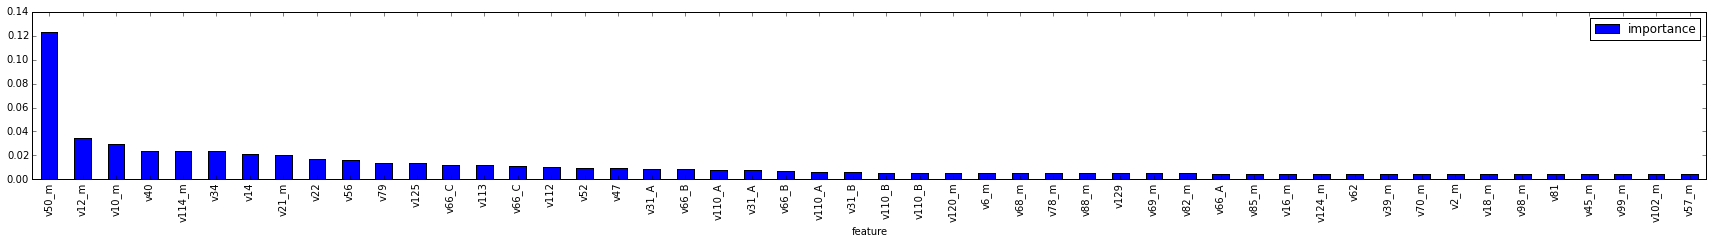

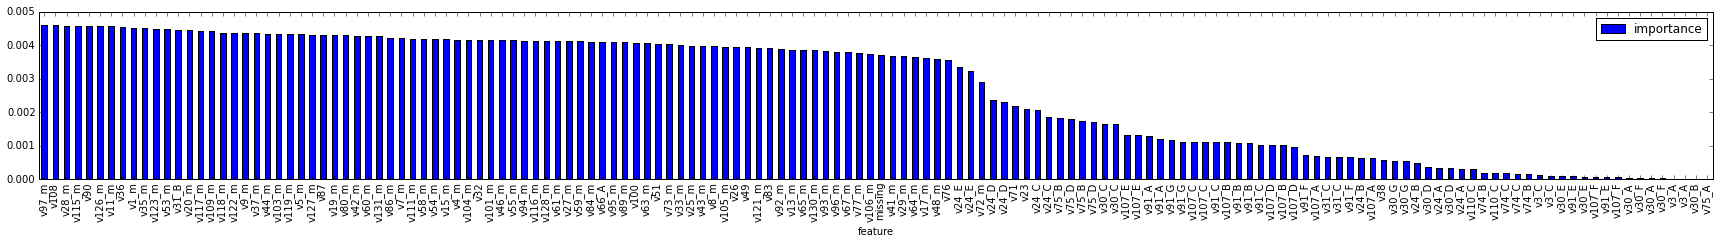

In [44]:
feature_analysis(grid_search.best_estimator_.steps[2][1], X_m2_train)

# Save

In [45]:
modelToSave = estimator
modelToSave = grid_search.best_estimator_

In [46]:
X_kaggleTest = prepareX(kaggleTest, False)

In [47]:
some_value = 'QFA'
for col, typ in X_m2_test.dtypes.iteritems():
    if typ == object:
        df = X_kaggleTest.loc[X_kaggleTest[col] == some_value]
        with pd.option_context('display.max_rows', 10, 'display.max_columns', 200):
            print df

Empty DataFrame
Columns: [v50_m, v56, v12_m, v114_m, v10_m, v34, v40, v66_C, v14, v79, v21_m, v22, v47, v125, v110_B, v66_B, v113, v110_A, v31_A, v112, v66_A, v52, v129, v62, v24_E, v31_B, v82_m, v115_m, v88_m, v6_m, v120_m, v119_m, v69_m, v124_m, v102_m, v24_D, v90, v57_m, v68_m, v1_m, v78_m, v99_m, v45_m, v16_m, v28_m, v126_m, v100, v87, v131_m, v98_m, v70_m, v36, v39_m, v108, v37_m, v81, v53_m, v85_m, v117_m, v58_m, v32, v27_m, v19_m, v122_m, v44_m, v42_m, v86_m, v7_m, v127_m, v11_m, v55_m, v9_m, v18_m, v103_m, v2_m, v123_m, v109_m, v80_m, v54_m, v25_m, v26, v73_m, v15_m, v97_m, v63_m, v20_m, v4_m, v89_m, v35_m, v118_m, v94_m, v5_m, v8_m, v116_m, v46_m, v104_m, v83, v49, v111_m, v105_m, ...]
Index: []

[0 rows x 212 columns]
           v50_m v56     v12_m     v114_m     v10_m        v34       v40  \
72596   1.087228  CY  7.576899  14.581211  2.625820   7.586965  9.346647   
98479   0.991856  DH  6.438124  15.854680  1.028447   7.792467  7.414081   
100840  2.886069  BW  7.877724  15

In [ ]:
X_m1_kaggleTest = model1.transform(X_kaggleTest)

Transform
Column proba: v30 is not in X, skip.
Column proba: v31 is not in X, skip.
Column proba: v91 is not in X, skip.
Column proba: v24 is not in X, skip.
Column proba: v74 is not in X, skip.
Column proba: v66 is not in X, skip.
Column proba: v110 is not in X, skip.
Column proba: v107 is not in X, skip.
Column proba: v3 is not in X, skip.
Column proba: v75 is not in X, skip.


In [ ]:
predic = modelToSave.predict_proba(X_m1_kaggleTest)[:,1] # extract 2nd column for X=1

In [ ]:
predicPd = pd.DataFrame(predic)
predicPd = predicPd.rename(columns={0: 'PredictedProb'})
predicPd['ID'] = kaggleTest[['ID']]
predicPd = predicPd[['ID', 'PredictedProb']]

In [ ]:
predicPd.to_csv("results/pythonpure/results.csv", index = False)